# AutoEncoder

### Imports

In [1]:
import torch
import os
import random
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms.functional as transformsF
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import time
import soundfile as sf
import glob

### Parameters

In [2]:
dataroot = "dagstuhl/solo"

# model params
batch_size = 1
ng = 32      # no. of feature maps to be extended from
num_epochs = 500
kernel_size = 4  # can be tuple
stride = 2       # can be tuple
padding = 1

# optimiser params
lr = 0.0002  # 0.001
beta1 = 0.9  #0.5
beta2 = 0.999
decay = 1e-5

# melspectrogram params
n_mels = 128
n_fft = 2048
hop_length = 512

sr = 22050   # sampling rate - don't change this
nc = 1       # no. of channels

CUDA = True
device = "cuda" if (torch.cuda.is_available() and CUDA) else "cpu"
print(torch.cuda.is_available())
print(device)

True
cuda


### Dataset and dataloaders

Custom dataloader using Dagstuhl Dataset. Melspectrograms are the extracted features from the WAV files, and are treated as if they are 2D images in the autoencoder architecture. They are also processed as a full sequence with non-fixed input sizes (achieved by implementing the model with only conv/deconv layers).

Individual, __solo__ recordings (of all microphone types) from the choir sessions were manually picked out from the dataset and reorganised into their respective directories which served as their 'labels'; these 'labels' then targeted the __full choir__ recording, which is used to discriminate the reconstructed melspectrograms. 

In essence, we are aiming to force the autoencoder to learn how to generate a choir recording (having Soprano, Alto, Tenor, Bass elements) given just a solo _a capella_ input by encoding-decoding the solo and comparing it with the choir. 

In [3]:
def create_mel_solo(path):
    wave, sr = librosa.load(path)
    mel = librosa.feature.melspectrogram(y=wave, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
    return torch.from_numpy(mel).to(device)

def create_mel_choir(class_idx):
    classes = {
    0: 'DCS_LI_FullChoir_Take01',
    1: 'DCS_LI_FullChoir_Take02',
    2: 'DCS_LI_FullChoir_Take03',
    3: 'DCS_TP_FullChoir_Take01',
    4: 'DCS_TP_FullChoir_Take02',
    5: 'DCS_TP_FullChoir_Take03',
    6: 'DCS_TP_FullChoir_Take04'
}
    wave, sr = librosa.load(f'dagstuhl/choir/{classes[class_idx]}.wav')
    mel = librosa.feature.melspectrogram(y=wave, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
    return torch.from_numpy(mel).to(device)


dataset = dset.DatasetFolder(root=dataroot, loader=create_mel_solo, extensions='.wav', target_transform=create_mel_choir)
# print(test.find_classes(dataroot))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

### Model

In [4]:
# conv2d(in_channel, out_channel, (kernel_size), (stride)=1, padding=0, dilation=1)
# convtranspose2d(in_channel, out_channel, (kernel_size)=(height, width), (stride)=1, padding=0, dilation=1)

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # if n_mels == 128, input_size is 1x128x_ (the following works well if n_mels is 2^ series)
        self.encoder = nn.Sequential(nn.Conv2d(nc, ng, kernel_size, stride, padding),
                                     nn.LeakyReLU(),
                                     # size now is 32x64x_
                                     nn.Conv2d(ng, ng*2, kernel_size, stride, padding),
                                     nn.LeakyReLU(),
                                     # size now is 64x32x_
                                     nn.Conv2d(ng*2, ng*4, kernel_size, stride, padding),
                                     nn.LeakyReLU(),
                                     # size now is 128x16x_
                                     nn.Conv2d(ng*4, ng*8, kernel_size, stride, padding),
                                     nn.LeakyReLU(),
                                     # size now is 256x8x_
                                     nn.Conv2d(ng*8, ng*16, kernel_size, stride, padding),
                                     nn.LeakyReLU()
                                     # size now is 512x4x_
                                    )

        self.decoder = nn.Sequential(nn.ConvTranspose2d(ng*16, ng*8, kernel_size, stride, padding),
                                     nn.LeakyReLU(),
                                     nn.ConvTranspose2d(ng*8, ng*4, kernel_size, stride, padding),
                                     nn.LeakyReLU(),
                                     nn.ConvTranspose2d(ng*4, ng*2, kernel_size, stride, padding),
                                     nn.LeakyReLU(),
                                     nn.ConvTranspose2d(ng*2, ng, kernel_size, stride, padding),
                                     nn.LeakyReLU(),
                                     nn.ConvTranspose2d(ng, nc, kernel_size, stride, padding),
                                     nn.LeakyReLU()
                                    )

    def forward(self,x):
        x = self.encoder(x)        
        x = self.decoder(x)
        return x

### Train model

In [5]:
torch.manual_seed(10)
model = Autoencoder().to(device)

distance = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(beta1,beta2), weight_decay = decay)

# For loading chkpt
# checkpoint = torch.load('')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# num_epochs -= checkpoint['epoch']

In [6]:
outputs_list = []
loss_list = []
start = time.time()

for epoch in range(num_epochs):
    for sample, target in dataloader:
        
        # Send data to device
        sample = Variable(sample).to(device)
        batch, height, width = sample.shape
        
        # Forward pass
        output = model(sample)
        # here's the iffy part; due to the input sizes all being arbitrary,
        # the conv/deconv layers automatically compensate for any dimensional constraints
        # leading to the reconstructed mel having a diff size than the choir recording
        # 'resize' is used here to interpolate the reconstruction to have the same dimension
        # perhaps a more academic solution would be better here
        output = transformsF.resize(output, (height, width))
        loss = distance(output, target)
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print('epoch {}/{}, loss {:.4f}'.format(epoch + 1, num_epochs, loss.item()))
    loss_list.append(loss.item())
    
    if ((epoch+1) % 50 == 0):
        torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
            }, 'chkpt.tar')
        outputs_list.append((epoch+1, target, output, loss.item()),)
        
        
end = time.time()
print(f"Total time taken: {(end-start)/60} min, for {num_epochs} epochs")

epoch 1/500, loss 489.7178
epoch 2/500, loss 634.6486
epoch 3/500, loss 821.2859
epoch 4/500, loss 637.2816
epoch 5/500, loss 758.1583
epoch 6/500, loss 399.8555
epoch 7/500, loss 628.6072
epoch 8/500, loss 466.8562
epoch 9/500, loss 321.9632
epoch 10/500, loss 452.1031
epoch 11/500, loss 288.5776
epoch 12/500, loss 674.9625
epoch 13/500, loss 471.5335
epoch 14/500, loss 439.2348
epoch 15/500, loss 323.3569
epoch 16/500, loss 386.5580
epoch 17/500, loss 363.7741
epoch 18/500, loss 497.9870
epoch 19/500, loss 691.2334
epoch 20/500, loss 376.4983
epoch 21/500, loss 425.2937
epoch 22/500, loss 327.2806
epoch 23/500, loss 351.8397
epoch 24/500, loss 394.1741
epoch 25/500, loss 375.2369
epoch 26/500, loss 257.6785
epoch 27/500, loss 210.0309
epoch 28/500, loss 301.4713
epoch 29/500, loss 216.0145
epoch 30/500, loss 244.9618
epoch 31/500, loss 225.1173
epoch 32/500, loss 175.4088
epoch 33/500, loss 258.8141
epoch 34/500, loss 155.4127
epoch 35/500, loss 259.7977
epoch 36/500, loss 165.6402
e

epoch 297/500, loss 8.8851
epoch 298/500, loss 9.1293
epoch 299/500, loss 7.6234
epoch 300/500, loss 10.9163
epoch 301/500, loss 9.5316
epoch 302/500, loss 8.9789
epoch 303/500, loss 8.5706
epoch 304/500, loss 9.9003
epoch 305/500, loss 5.8198
epoch 306/500, loss 10.4856
epoch 307/500, loss 6.5756
epoch 308/500, loss 10.9988
epoch 309/500, loss 8.7120
epoch 310/500, loss 9.2889
epoch 311/500, loss 9.8734
epoch 312/500, loss 10.3317
epoch 313/500, loss 6.6592
epoch 314/500, loss 7.1145
epoch 315/500, loss 9.3294
epoch 316/500, loss 8.2274
epoch 317/500, loss 9.3073
epoch 318/500, loss 7.7472
epoch 319/500, loss 6.8898
epoch 320/500, loss 8.4649
epoch 321/500, loss 12.4142
epoch 322/500, loss 7.3612
epoch 323/500, loss 7.4041
epoch 324/500, loss 9.8434
epoch 325/500, loss 10.7355
epoch 326/500, loss 9.8846
epoch 327/500, loss 17.1362
epoch 328/500, loss 13.0636
epoch 329/500, loss 8.2612
epoch 330/500, loss 7.4660
epoch 331/500, loss 6.8664
epoch 332/500, loss 7.5289
epoch 333/500, loss 

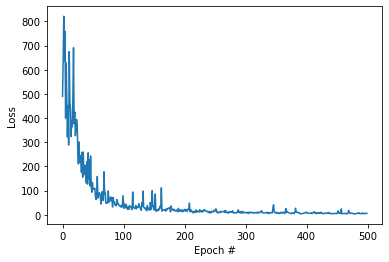

In [7]:
# Display loss
plt.figure()
plt.plot(loss_list)
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.show()

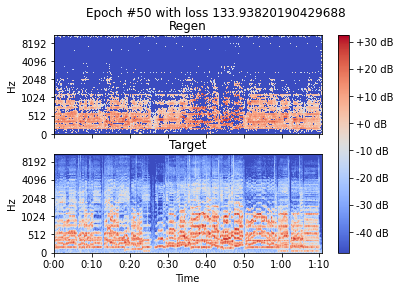

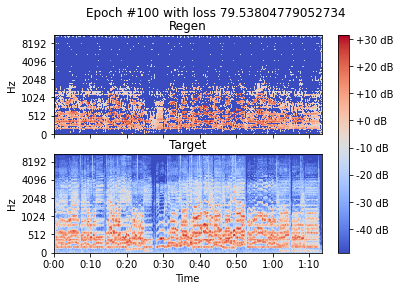

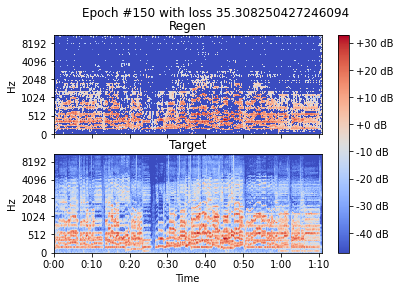

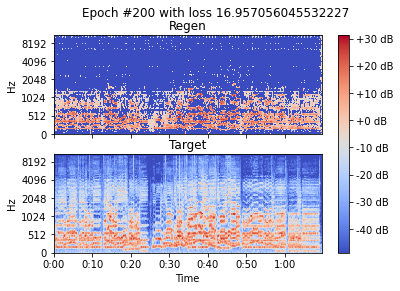

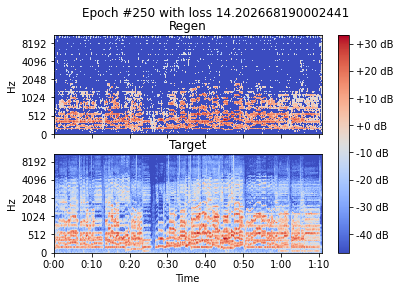

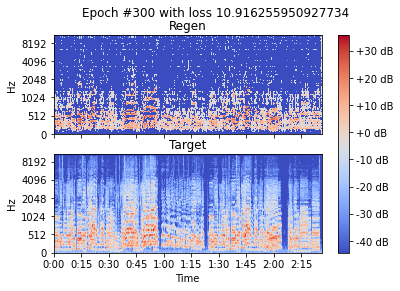

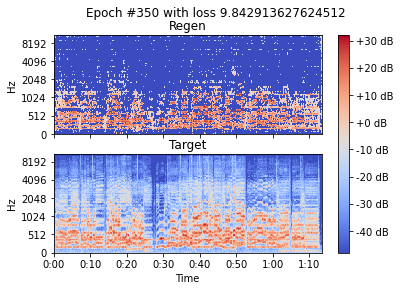

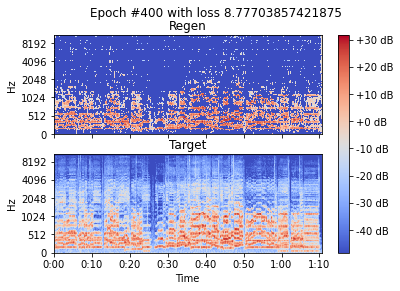

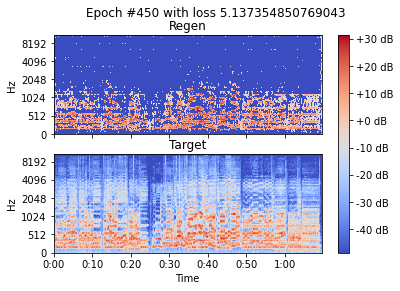

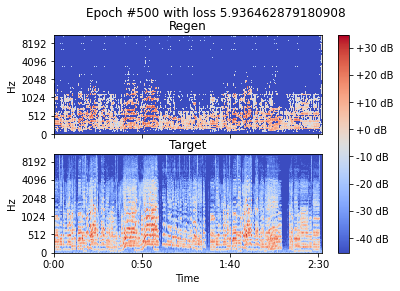

In [8]:
# Display some outputs
for k in range(0, len(outputs_list)):
    fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
    fig.suptitle(f"Epoch #{outputs_list[k][0]} with loss {outputs_list[k][3]}")
    target = outputs_list[k][1].cpu().detach()
    recon = outputs_list[k][2].cpu().detach()

    mel = librosa.power_to_db(torch.squeeze(recon).numpy())
    img = librosa.display.specshow(mel, x_axis='time', y_axis='mel', ax=ax[0])
    ax[0].set(title='Regen')
    ax[0].label_outer()
    
    mel = librosa.power_to_db(torch.squeeze(target).numpy())
    librosa.display.specshow(mel, x_axis='time', y_axis='mel', ax=ax[1])
    ax[1].set(title='Target')
    ax[1].label_outer()
    fig.colorbar(img, ax=ax, format="%+2.f dB")
        

### Testing/Predictions

In [9]:
def write_audio(mel, sr, name):
    # the inverse function takes an obscenely long amt of time...
    start = time.time()
    audio = librosa.feature.inverse.mel_to_audio(mel)
    sf.write(f"{name}.wav", audio, sr)
    end = time.time()
    print(f"Total time taken: {(end-start)/60} min to write {name}.wav")

In [10]:
torch.save(model, 'model.pth')
write_audio(torch.squeeze(outputs_list[-1][2].cpu().detach()).numpy(), 22050, 'last_epoch')

Total time taken: 13.175127788384755 min to write last_epoch.wav


In [11]:
def predict(path):
    evalModel = torch.load('model.pth')
    evalModel.eval()
    wave, sr = librosa.load(path, sr=None)
    mel = librosa.feature.melspectrogram(y=wave, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
    output = evalModel(torch.from_numpy(np.expand_dims(mel, axis=0)).to(device))
    write_audio(torch.squeeze(output.cpu().detach()).numpy(), sr, f'{path[:-4]}-reconstructed')

In [12]:
for test_audio in glob.glob('test/*.wav'):
    predict(test_audio)

Total time taken: 11.938094822565715 min to write test\01_1-reconstructed.wav
Total time taken: 9.850587956110637 min to write test\01_2-reconstructed.wav
Total time taken: 10.465567247072856 min to write test\02-reconstructed.wav
Total time taken: 14.060304629802705 min to write test\03-reconstructed.wav
Total time taken: 8.187034781773885 min to write test\12_1-reconstructed.wav
Total time taken: 9.556120491027832 min to write test\12_2-reconstructed.wav


(128, 2976)


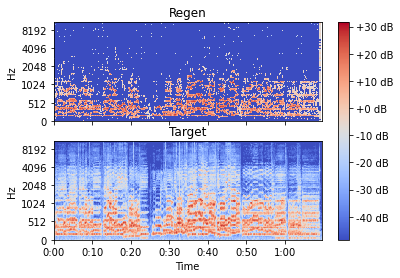

In [13]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
wave, sr = librosa.load('dagstuhl\solo\DCS_TP_FullChoir_Take03\DCS_TP_FullChoir_Take03_A2_DYN.wav', sr=None)
mel = librosa.feature.melspectrogram(y=wave)
model.eval()
output = model(torch.from_numpy(np.expand_dims(mel, axis=0)).to(device))
output = librosa.power_to_db(torch.squeeze(output.cpu().detach()).numpy())
print(output.shape)
img = librosa.display.specshow(output, x_axis='time', y_axis='mel', ax=ax[0])
ax[0].set(title='Regen')
ax[0].label_outer()

wave,sr = librosa.load('dagstuhl\choir\DCS_TP_FullChoir_Take03.wav', sr=None)
mel = librosa.feature.melspectrogram(y=wave)
mel = librosa.power_to_db(mel)
librosa.display.specshow(mel, x_axis='time', y_axis='mel', ax=ax[1])
ax[1].set(title='Target')
ax[1].label_outer()
fig.colorbar(img, ax=ax, format="%+2.f dB")